In [108]:
# NOTEBOOK FOR BATCH PROCESSING SEGMENTATION

In [1]:
import numpy as np
import pandas as pd
import tifffile as tf
from cellpose import models
from cellpose import utils
from skimage.measure import label, regionprops
import os
from tqdm import tqdm
from scipy.spatial.distance import cdist
from skimage.segmentation import expand_labels, watershed
import matplotlib.pyplot as plt

In [2]:
path_unsegmented_datasets='../../figures/2.comparison_between_datasets/input_for_segmentation/'
datasets=os.listdir(path_unsegmented_datasets)

In [3]:
datasets

['.ipynb_checkpoints',
 'CosMx',
 'HybrISS',
 'MERFISH_ABI',
 'ResolvedBiosciences',
 'Vizgen',
 'Xenium']

In [4]:
## COSMX DATASET BREAKS TO SEGMENT
## VIZGEN DATASET DOESN'T HAVE A GOOD CORRESPONDANCE TO READS. WE NEED TO APPLY A TRANSFORMATION (MAYBE?)

In [5]:
datasets[3:4]

['MERFISH_ABI']

In [21]:
read_positions

,x,y,gene,in_cell,closest_cell,closest_cell_x,closest_cell_y,distance_to_centroid
0,1144.477903,13552.491550,Gad2,0,2264,13717.486919,925.458264,274.213556
1,1588.995502,13582.341800,Gad2,0,2274,13732.895250,1544.198538,157.076762
2,1267.310660,13908.710758,Gad2,0,2301,13843.323077,1205.792308,89.777818
3,1348.869034,14262.668448,Gad2,0,2447,14336.958635,1104.684739,255.235189
4,718.486967,14309.599166,Gad2,0,2455,14377.015746,802.091283,107.399612
...,...,...,...,...,...,...,...,...
3841407,18476.752336,5929.604218,Mup5,0,621,5917.491773,18618.466179,142.230534
3841408,17908.483115,6196.583614,Mup5,0,691,6341.125720,18020.181247,182.671545
3841409,17769.324682,6892.901948,Mup5,0,788,6832.624052,17724.601300,75.057349
3841410,17489.556850,7306.316326,Mup5,0,867,7212.881928,17461.033735,97.691120


MERFISH_ABI
starting segmentation...


100%|██████████████████████████████████████████████████████████████████████| 3841412/3841412 [02:33<00:00, 25053.62it/s]
/tmp/ipykernel_575517/923599675.py:58: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata=sc.AnnData(cellxgene)
/home/sergio/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


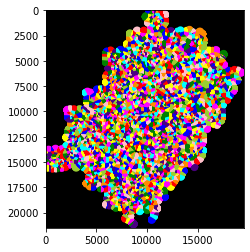

In [43]:
for ds in datasets[3:4]:
    print(ds)
    try:
        dapi_image = tf.imread(path_unsegmented_datasets+ds+'/DAPI.tif')
    except:
        dapi_image = tf.imread(path_unsegmented_datasets+ds+'/DAPI.tiff')
    read_positions = pd.read_csv(path_unsegmented_datasets+ds+'/transcripts.csv',index_col=0)
    if ds=='CosMx':
        read_positions['x']=read_positions['y_global_px']
        read_positions['y']=read_positions['x_global_px']
        read_positions['x']=read_positions['x']-np.min(read_positions['x'])
        read_positions['y']=read_positions['y']-np.min(read_positions['y'])
    if ds in ['MERFISH_ABI']:
        read_positions['x']=(read_positions['x']-read_positions['x'].min())*9.28
        read_positions['y']=(read_positions['y']-read_positions['y'].min())*9.28
    if ds in ['Vizgen']:
        read_positions['x']=read_positions['global_x']*9.20586
        read_positions['y']=read_positions['global_y']*9.20586
    if ds in ['Xenium']:
        read_positions['x']=read_positions['x']*4.70588
        read_positions['y']=read_positions['y']*4.70588
    #plt.figure(figsize=(7,7))
    #plt.imshow(dapi_image,vmax=1200)
    #plt.scatter(read_positions['x'],read_positions['y'],s=0.001,c='red')
    # Initialize Cellpose model for nuclei segmentation
    model = models.Cellpose(gpu=False, model_type='nuclei')
    # Segment nuclei
    print('starting segmentation...')
    masks, flows, styles, diams = model.eval(dapi_image, diameter=None, channels=[0, 0])
    # Label the segmented nuclei
    labeled_nuclei = label(masks)
    expanded_nuclei = expand_labels(labeled_nuclei, distance=400)
    from skimage.color import label2rgb
    color1 = label2rgb(expanded_nuclei, bg_label=0)
    plt.imshow(color1)
    centroid_dictx={}
    centroid_dicty={}
    for nucleus_props in regionprops(labeled_nuclei):
        centroid_dictx[nucleus_props.label]=nucleus_props.centroid[0]
        centroid_dicty[nucleus_props.label]=nucleus_props.centroid[1]
    closest_cell=[]
    in_cell=[]
    for ind in tqdm(read_positions.index):
        try:
            in_cell.append(labeled_nuclei[int(read_positions.loc[ind,'y']),int(read_positions.loc[ind,'x'])])
            closest_cell.append(expanded_nuclei[int(read_positions.loc[ind,'y']),int(read_positions.loc[ind,'x'])])
        except:
            in_cell.append(0)
            closest_cell.append(0)
    read_positions['in_cell']=in_cell
    read_positions['closest_cell']=closest_cell
    read_positions['closest_cell_x']=read_positions['closest_cell'].map(centroid_dictx)
    read_positions['closest_cell_y']=read_positions['closest_cell'].map(centroid_dicty)
    read_positions['distance_to_centroid']=np.sqrt((read_positions['closest_cell_y']-read_positions['y'])**2 +(read_positions['closest_cell_x']-read_positions['x'])**2)
    cellxgene=pd.crosstab(read_positions['in_cell'],read_positions['gene'])
    cellxgene=cellxgene.loc[~cellxgene.index.isin([0]),:]
    import scanpy as sc
    adata=sc.AnnData(cellxgene)
    adata.obs['x_centroid']=adata.obs.index.astype(int).map(centroid_dictx)
    adata.obs['y_centroid']=adata.obs.index.astype(int).map(centroid_dicty)
    adata.write(path_unsegmented_datasets+ds+'/adata.h5ad')
    read_positions.to_csv(path_unsegmented_datasets+ds+'/transcripts_with_cell_assignment.csv')

In [46]:
read_positions.to_csv(path_unsegmented_datasets+ds+'/transcripts_with_cell_assignment.csv')

In [52]:
read_positions['distance_to_centroid']=np.sqrt((read_positions['closest_cell_x']-read_positions['x'])**2 +(read_positions['closest_cell_y']-read_positions['y'])**2)

In [53]:
np.mean(read_positions['distance_to_centroid'])

8693.853373323924

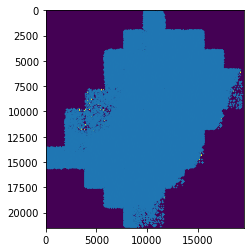

In [10]:
plt.figure()
plt.imshow(labeled_nuclei,vmax=10)
plt.scatter(read_positions['x'],read_positions['y'],s=0.1)

In [28]:
ds=datasets[3]
read_positions = pd.read_csv(path_unsegmented_datasets+ds+'/transcripts.csv',index_col=0)

In [38]:
1/0.16

6.25

In [39]:
read_positions['x2']=(read_positions['x']-read_positions['x'].min())*9.28#20586
read_positions['y2']=(read_positions['y']-read_positions['y'].min())*9.28#20586

(9000.0, 14500.0)

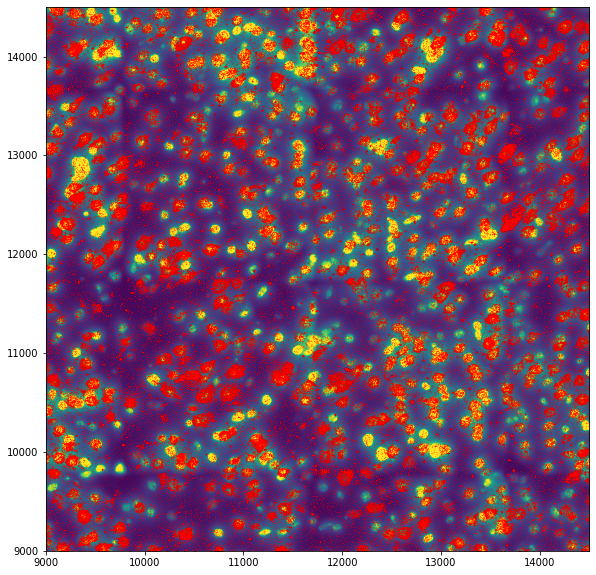

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(dapi_image,vmax=10000)
plt.scatter(read_positions['x'],read_positions['y'],s=0.004,color='red')
plt.xlim(9000,14500)
plt.ylim(9000,14500)

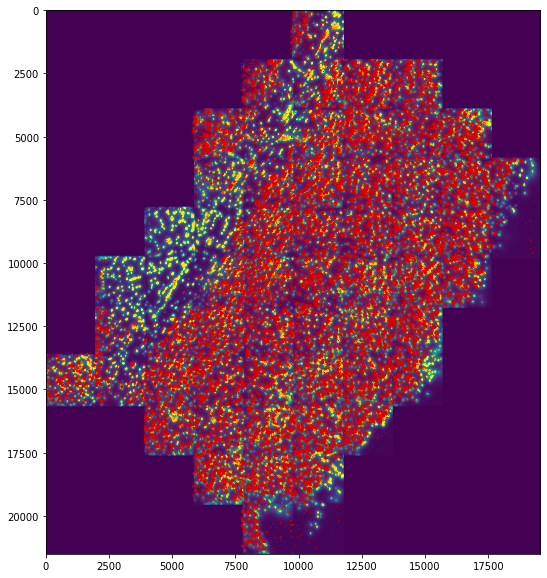

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(dapi_image,vmax=10000)
plt.scatter(read_positions['x2'],read_positions['y2'],s=0.0001,color='red')
#plt.xlim(9000,14500)
#plt.ylim(9000,14500)

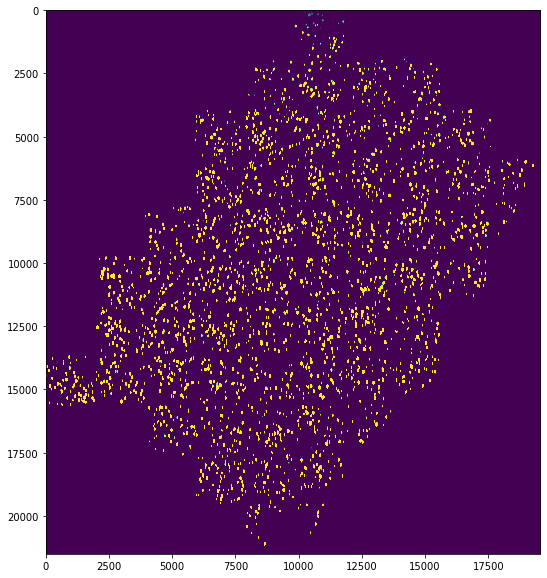

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(labeled_nuclei,vmax=10)
#plt.scatter(read_positions['x'],read_positions['y'],s=0.001,color='red')
#plt.xlim(1000,14500)
#plt.ylim(1000,14500)

In [44]:
closest_cell=[]
in_cell=[]
for ind in tqdm(read_positions.index):
    try:
        in_cell.append(labeled_nuclei[int(read_positions.loc[ind,'y']),int(read_positions.loc[ind,'x'])])
        closest_cell.append(expanded_nuclei[int(read_positions.loc[ind,'y']),int(read_positions.loc[ind,'x'])])
    except:
        in_cell.append(0)
        closest_cell.append(0)

100%|██████████████████████████████████████████████████████████████████████| 3841412/3841412 [03:19<00:00, 19267.67it/s]


In [45]:
read_positions['in_cell']=in_cell
read_positions['closest_cell']=closest_cell
read_positions['closest_cell_x']=read_positions['closest_cell'].map(centroid_dictx)
read_positions['closest_cell_y']=read_positions['closest_cell'].map(centroid_dicty)
read_positions['distance_to_centroid']=np.sqrt((read_positions['closest_cell_y']-read_positions['y'])**2 +(read_positions['closest_cell_x']-read_positions['x'])**2)
cellxgene=pd.crosstab(read_positions['in_cell'],read_positions['gene'])
cellxgene=cellxgene.loc[~cellxgene.index.isin([0]),:]
import scanpy as sc
adata=sc.AnnData(cellxgene)
adata.obs['x_centroid']=adata.obs.index.astype(int).map(centroid_dictx)
adata.obs['y_centroid']=adata.obs.index.astype(int).map(centroid_dicty)
adata.write(path_unsegmented_datasets+ds+'/adata.h5ad')

/tmp/ipykernel_393311/2483377486.py:9: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata=sc.AnnData(cellxgene)
/home/sergio/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


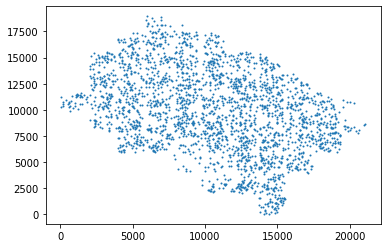

In [49]:
plt.scatter(adata.obs['x_centroid'],adata.obs['y_centroid'],s=1)

In [ ]:
closest_cell=[]
in_cell=[]
for ind in tqdm(read_positions.index):
    try:
        in_cell.append(labeled_nuclei[read_positions.loc[ind,'y'],read_positions.loc[ind,'x']])
        closest_cell.append(expanded_nuclei[read_positions.loc[ind,'y'],read_positions.loc[ind,'x']])
    except:
        in_cell.append(0)
        closest_cell.append(0)
read_positions['in_cell']=in_cell
read_positions['closest_cell']=closest_cell
read_positions['closest_cell_x']=read_positions['closest_cell'].map(centroid_dictx)
read_positions['closest_cell_y']=read_positions['closest_cell'].map(centroid_dicty)
read_positions['distance_to_centroid']=np.sqrt((read_positions['closest_cell_y']-read_positions['y'])**2 +(read_positions['closest_cell_x']-read_positions['x'])**2)
cellxgene=pd.crosstab(read_positions['in_cell'],read_positions['gene'])
cellxgene=cellxgene.loc[~cellxgene.index.isin([0]),:]
import scanpy as sc
adata=sc.AnnData(cellxgene)
adata.obs['x_centroid']=adata.obs.index.astype(int).map(centroid_dictx)
adata.obs['y_centroid']=adata.obs.index.astype(int).map(centroid_dicty)

In [ ]:
for ds in datasets[5:6]:
    print(ds)
    try:
        dapi_image = tf.imread(path_unsegmented_datasets+ds+'/DAPI.tif')
    except:
        dapi_image = tf.imread(path_unsegmented_datasets+ds+'/DAPI.tiff')
    read_positions = pd.read_csv(path_unsegmented_datasets+ds+'/transcripts.csv',index_col=0)
    if ds=='CosMx':
        read_positions['x']=read_positions['y_global_px']
        read_positions['y']=read_positions['x_global_px']
        read_positions['x']=read_positions['x']-np.min(read_positions['x'])
        read_positions['y']=read_positions['y']-np.min(read_positions['y'])
    if ds in ['MERFISH_ABI']:
        read_positions['x']=(read_positions['x_um']-read_positions['x_um'].min())*9.20586
        read_positions['y']=(read_positions['y_um']-read_positions['y_um'].min())*9.20586
    if ds in ['Vizgen']:
        read_positions['x']=read_positions['global_x']*9.20586
        read_positions['y']=read_positions['global_y']*9.20586
    if ds in ['Xenium']:
        read_positions['x']=read_positions['x']*4.70588
        read_positions['y']=read_positions['y']*4.70588
    #plt.figure(figsize=(7,7))
    #plt.imshow(dapi_image,vmax=1200)
    #plt.scatter(read_positions['x'],read_positions['y'],s=0.001,c='red')
   
    # Initialize Cellpose model for nuclei segmentation
    model = models.Cellpose(gpu=False, model_type='nuclei')
    # Segment nuclei
    print('starting segmentation...')
    masks, flows, styles, diams = model.eval(dapi_image, diameter=None, channels=[0, 0])
    # Label the segmented nuclei
    labeled_nuclei = label(masks)
    expanded_nuclei = expand_labels(labeled_nuclei, distance=400)
    from skimage.color import label2rgb
    color1 = label2rgb(expanded_nuclei, bg_label=0)
    plt.imshow(color1)
    centroid_dictx={}
    centroid_dicty={}
    for nucleus_props in regionprops(labeled_nuclei):
        centroid_dictx[nucleus_props.label]=nucleus_props.centroid[0]
        centroid_dicty[nucleus_props.label]=nucleus_props.centroid[1]
    closest_cell=[]
    in_cell=[]
    for ind in tqdm(read_positions.index):
        try:
            in_cell.append(labeled_nuclei[read_positions.loc[ind,'x'],read_positions.loc[ind,'y']])
            closest_cell.append(expanded_nuclei[read_positions.loc[ind,'x'],read_positions.loc[ind,'y']])
        except:
            in_cell.append(0)
            closest_cell.append(0)
    read_positions['in_cell']=in_cell
    read_positions['closest_cell']=closest_cell
    read_positions['closest_cell_x']=read_positions['closest_cell'].map(centroid_dictx)
    read_positions['closest_cell_y']=read_positions['closest_cell'].map(centroid_dicty)
    read_positions['distance_to_centroid']=np.sqrt((read_positions['closest_cell_y']-read_positions['y'])**2 +(read_positions['closest_cell_x']-read_positions['x'])**2)
    cellxgene=pd.crosstab(read_positions['in_cell'],read_positions['gene'])
    cellxgene=cellxgene.loc[~cellxgene.index.isin([0]),:]
    import scanpy as sc
    adata=sc.AnnData(cellxgene)
    adata.obs['x_centroid']=adata.obs.index.astype(int).map(centroid_dictx)
    adata.obs['y_centroid']=adata.obs.index.astype(int).map(centroid_dicty)
    adata.write(path_unsegmented_datasets+ds+'/adata.h5ad')
    read_positions.to_csv(path_unsegmented_datasets+ds+'/transcripts_with_cell_assignment.csv')

Xenium
starting segmentation...


In [3]:
ds='CosMx'

In [5]:
dapi_image = tf.imread(path_unsegmented_datasets+ds+'/DAPI.tiff')
tile_size=[2000,2000]
overlap=100
tile_positions = []
segmented_masks = []
from tqdm import tqdm

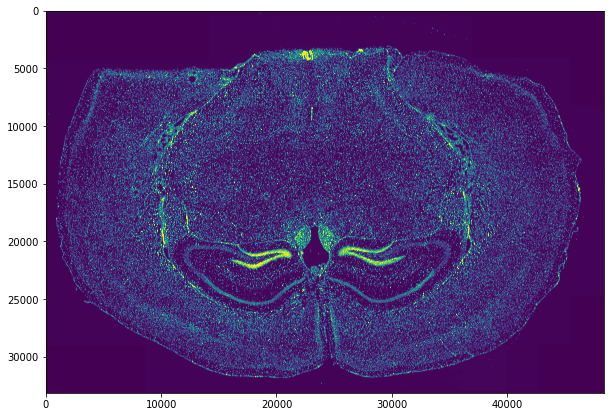

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(dapi_image,vmax=3000)

In [4]:
read_positions = pd.read_csv(path_unsegmented_datasets+ds+'/transcripts.csv',index_col=0)

In [5]:
read_positions['x']=read_positions['y_global_px']
read_positions['y']=read_positions['x_global_px']
read_positions['x']=read_positions['x']-np.min(read_positions['x'])
read_positions['y']=read_positions['y']-np.min(read_positions['y'])

In [ ]:
height, width = dapi_image.shape[:2]

for y in tqdm(range(0, height, tile_size[1] - overlap)):
    for x in tqdm(range(0, width, tile_size[0] - overlap)):
        # Calculate tile boundaries
        x1, x2 = x, min(x + tile_size[0], width)
        y1, y2 = y, min(y + tile_size[1], height)

        # Extract the tile
        tile = dapi_image[y1:y2, x1:x2]

        # Store the tile position
        tile_positions.append((x1, y1))

        # Step 2: Segment each tile with Cellpose
        # Initialize Cellpose model
        model = models.Cellpose(gpu=False)  # You can set GPU to True if available

        # Run Cellpose on each tile
        masks, _, _, _ = model.eval(tile, channels=[0, 0], diameter=None)  # Modify channels and diameter as needed
        
        segmented_masks.append(masks)

  0%|                                                                                            | 0/26 [00:00<?, ?it/s]

In [ ]:
mask.shape

In [11]:
# Step 3: Recompose the segmented masks into a single mask
full_mask = np.zeros((height, width), dtype=np.uint8)

for mask, position in tqdm(zip(segmented_masks, tile_positions)):
    x, y = position
    h, w = mask.shape[:2]
    full_mask[y:y + h, x:x + w] = mask # Assuming you want only one channel of the mask

468it [00:01, 344.53it/s]


In [12]:
np.max(full_mask)

255

In [19]:
# Display the final mask (for visualization purposes)
plt.figure(figsize=(10,10))
plt.imshow(full_mask,vmax=1)
plt.scatter(read_positions.x,read_positions.y,s=0.01)

NameError: name 'full_mask' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
# Optional: Save the full mask to a file
tf.imwrite(path_unsegmented_datasets+ds+"segmented_mask.tif", full_mask)

In [4]:
#read_positions = pd.read_csv(path_unsegmented_datasets+ds+'/transcripts.csv',index_col=0)

In [6]:
# Optional: Save the full mask to a file
full_mask=tf.imread(path_unsegmented_datasets+ds+"/segmented_mask.tif")

In [6]:
# this is for xenium
from tqdm import tqdm
read_positions['x']=read_positions['x']*4.70588
read_positions['y']=read_positions['y']*4.70588

In [7]:
read_positions['x']=read_positions['y_global_px']
read_positions['y']=read_positions['x_global_px']
read_positions['x']=np.max(read_positions['x'])-read_positions['x']
read_positions['y']=np.max(read_positions['y'])-read_positions['y']

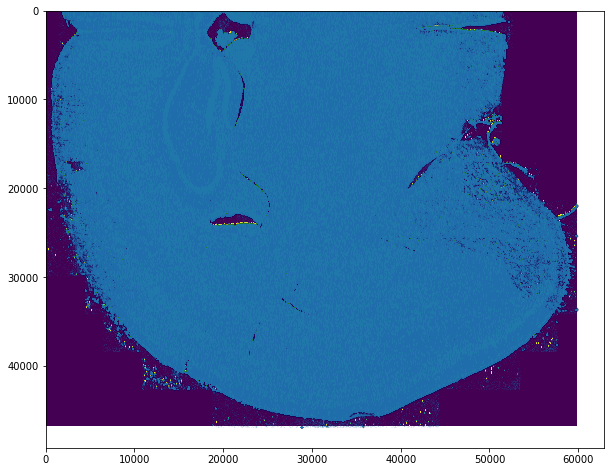

In [26]:
# Display the final mask (for visualization purposes)
plt.figure(figsize=(10,10))
plt.imshow(full_mask,vmax=1)
plt.scatter(read_positions.x,read_positions.y,s=0.001)

In [8]:
bin_mask=(full_mask>0)*1

In [9]:
labeled_nuclei = label(bin_mask)

In [10]:
del bin_mask
del full_mask

In [15]:
read_positions['in_cell']=0
read_positions['closest_cell']=0

In [12]:
#labeled_nuclei = label(masks)
expanded_nuclei = expand_labels(labeled_nuclei, distance=400)
centroid_dictx={}
centroid_dicty={}
for nucleus_props in regionprops(labeled_nuclei):
    centroid_dictx[nucleus_props.label]=nucleus_props.centroid[0]
    centroid_dicty[nucleus_props.label]=nucleus_props.centroid[1]
closest_cell=[]
in_cell=[]

In [ ]:
print('starting with assignment')
for ind in tqdm(read_positions.index):
    try:
        in_cell.append(labeled_nuclei[int(read_positions.loc[ind,'x']),int(read_positions.loc[ind,'y'])])
        closest_cell.append(expanded_nuclei[int(read_positions.loc[ind,'x']),int(read_positions.loc[ind,'y'])])
    except:
        in_cell.append(0)
        closest_cell.append(0)

starting with assignment


 82%|██████████████████████████████████████████████████████▊            | 94965425/116159827 [56:53<13:53, 25440.19it/s]

In [8]:
np.max(in_cell)

NameError: name 'in_cell' is not defined

In [ ]:
read_positions['in_cell']=in_cell
read_positions['closest_cell']=closest_cell

In [ ]:
read_positions['closest_cell_x']=read_positions['closest_cell'].map(centroid_dictx)
read_positions['closest_cell_y']=read_positions['closest_cell'].map(centroid_dicty)
read_positions['distance_to_centroid']=np.sqrt((read_positions['closest_cell_y']-read_positions['y'])**2 +(read_positions['closest_cell_x']-read_positions['x'])**2)

In [ ]:
cellxgene=pd.crosstab(read_positions['in_cell'],read_positions['gene'])
cellxgene=cellxgene.loc[~cellxgene.index.isin([0]),:]
import scanpy as sc
adata=sc.AnnData(cellxgene)
adata.obs['x_centroid']=adata.obs.index.astype(int).map(centroid_dictx)
adata.obs['y_centroid']=adata.obs.index.astype(int).map(centroid_dicty)
adata.write(path_unsegmented_datasets+ds+'/adata.h5ad')
read_positions.to_csv(path_unsegmented_datasets+ds+'/transcripts_with_cell_assignment.csv')

In [ ]:


# Step 2: Segment each tile with Cellpose
segmented_masks = []

# Initialize Cellpose model
model = models.Cellpose(gpu=False)  # You can set GPU to True if available

for tile in tiles:
    # Run Cellpose on each tile
    masks, _, _, _ = model.eval(tile, channels=[0, 0], diameter=30)  # Modify channels and diameter as needed
    segmented_masks.append(masks)

# Step 3: Recompose the segmented masks into a single mask
original_image_shape = large_image.shape[:2]

full_mask = np.zeros(original_image_shape, dtype=np.uint8)

for mask, position in zip(segmented_masks, tile_positions):
    x, y = position
    h, w = mask.shape[:2]
    full_mask[y:y + h, x:x + w] = mask[..., 0]  # Assuming you want only one channel of the mask

# 'full_mask' now contains the segmentation mask for the entire image

# Optional: Save the full mask to a file
cv2.imwrite("segmented_mask.jpg", full_mask)

# Optional: Perform post-processing on the 'full_mask' if needed

# Display the final mask (for visualization purposes)
cv2.imshow("Segmented Mask", full_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import numpy as np

# Assuming 'segmented_masks' is a list of segmented masks for each tile
# and 'tile_positions' is a list of the positions of each tile in the original image

# Determine the shape of the original image
original_image_shape = (height, width)

# Create an empty mask of the same shape as the original image
full_mask = np.zeros(original_image_shape, dtype=np.uint8)

# Iterate through the segmented masks and tile positions
for mask, position in zip(segmented_masks, tile_positions):
    x, y = position  # Position of the top-left corner of the tile
    h, w = mask.shape  # Height and width of the tile
    full_mask[y:y + h, x:x + w] = mask

# 'full_mask' now contains the segmentation mask for the entire image


In [8]:
datasets=['CosMx','Vizgen','Xenium']

In [6]:
for ds in datasets:
    if os.path.exists(path_unsegmented_datasets+ds+'/transcripts_with_cell_assignment.csv'):
        print(ds)
   

HybrISS
MERFISH_ABI
ResolvedBiosciences
